In [ ]:
# !pip install numpy pandas seaborn matplotlib scikit-learn safetensors
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# # reben requiring python > 3.9  but < 3.12
# !pip install git+https://git.tu-berlin.de/rsim/reben-training-scripts.git
# !pip install configilm torchsummary

In [64]:
import os
import time
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import rasterio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, ConvNextV2Model
import timm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Train model on wealth index directly

**direct vit base** seems to give most reasonable looking results.

In [2]:
class VitBaseForRegression(nn.Module):
    def __init__(self, base_model):
        super(VitBaseForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 1),
            nn.Sigmoid()
        )

        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = VitBaseForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [3]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    # transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms
test_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
    'test': test_transform
}

In [4]:
# Load target information
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw.drop(columns='DHSCLUST', inplace=True)
df_target_raw = df_target_raw.astype({'target':'float32'})

In [5]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [6]:
# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# Perform train test split
ind_training, ind_test = train_test_split(df_target.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# MinMaxScale to target
scaler = MinMaxScaler()
df_target.loc[ind_train,'target'] = scaler.fit_transform(df_target.loc[ind_train,['target']])
df_target.loc[ind_val,'target'] = scaler.transform(df_target.loc[ind_val,['target']])
df_target.loc[ind_test,'target'] = scaler.transform(df_target.loc[ind_test,['target']])

# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=data_transforms['train'])
val_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=data_transforms['val'])
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=data_transforms['test'])

# Determine the sizes for the different datasets
total_size, train_val_size, train_size, val_size, test_size = len(df_target), len(ind_train) + len(ind_val), len(ind_train), len(ind_val), len(ind_test)
dataset_sizes = {'train':train_size, 'val':val_size, 'test': test_size}

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4),
    'test': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [7]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 0m 54s


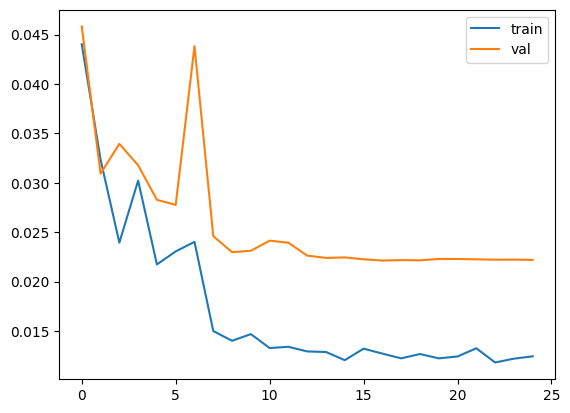

In [8]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

In [9]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

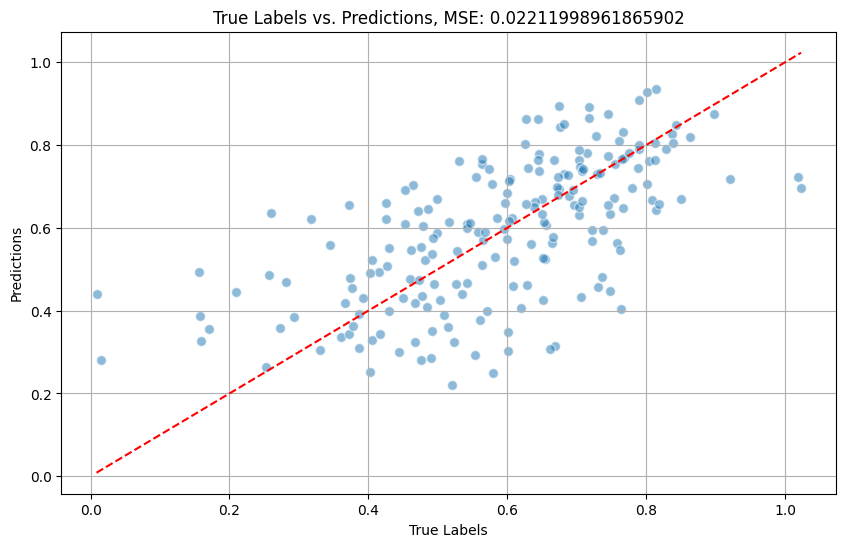

In [10]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()

### Train model on nightlight

As before, direct vit base seems to be the best approach.

In [134]:
class VitBaseForRegression2(nn.Module):
    def __init__(self, base_model):
        super(VitBaseForRegression2, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 512),  # First layer
            nn.BatchNorm1d(512),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            
            nn.Linear(512, 256),                      # Second layer
            nn.BatchNorm1d(256),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            
            nn.Linear(256, 128),                      # Third layer
            nn.BatchNorm1d(128),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            
            nn.Linear(128, 1),                        # Output layer
        )
        
        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = VitBaseForRegression2(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.00001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [135]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    # transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms
test_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
    'test': test_transform
}

In [136]:
# Load target information, log transform then min max scale
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw = df_target_raw[['filename','target']]
df_target_raw = df_target_raw.astype({'target':'float32'})

In [137]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target


In [138]:
# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# Perform train test split
ind_training, ind_test = train_test_split(df_target.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# # MinMaxScale + log to target
# scaler = MinMaxScaler()
# df_target.loc[ind_train,'target'] = scaler.fit_transform(np.log(df_target.loc[ind_train,['target']]))
# df_target.loc[ind_val,'target'] = scaler.transform(np.log(df_target.loc[ind_val,['target']]))
# df_target.loc[ind_test,'target'] = scaler.transform(np.log(df_target.loc[ind_test,['target']]))

# # log transform target
# df_target.loc[ind_train,'target'] = np.log(df_target.loc[ind_train,['target']])
# df_target.loc[ind_val,'target'] = np.log(df_target.loc[ind_val,['target']])
# df_target.loc[ind_test,'target'] = np.log(df_target.loc[ind_test,['target']])

# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=data_transforms['train'])
val_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=data_transforms['val'])
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=data_transforms['test'])

# Determine the sizes for the different datasets
total_size, train_val_size, train_size, val_size, test_size = len(df_target), len(ind_train) + len(ind_val), len(ind_train), len(ind_val), len(ind_test)
dataset_sizes = {'train':train_size, 'val':val_size, 'test': test_size}

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4,drop_last=True),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4,drop_last=True),
    'test': DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4,drop_last=True)
}

In [139]:
# Training code
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()
    df = pd.DataFrame({'train':np.zeros([num_epochs]), 'val':np.zeros([num_epochs])})
    
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 0m 23s


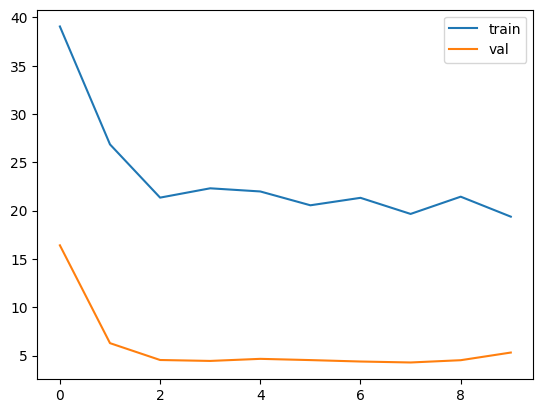

In [140]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10,verbose=0,plot_curves=True)

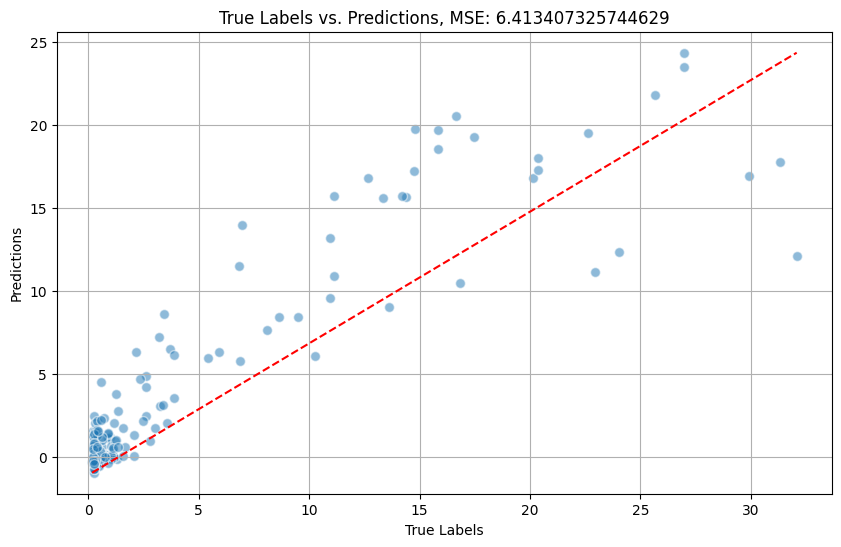

In [142]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_outputs), max(all_outputs)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

### Using daytime sat as additional feature

vit base seems to work best. tried for:
1. bigearthnet vit base vs direct vit base
2. log y, minmaxscale(log y), larger fc network, and larger fc network + minmaxscale(log y).

note: single linear layer ones need sigmoid to prevent exploding gradients

decided on:
1. daysat direct as additional feature - direct vit base + small network + sigmoid
2. transfer model as additional feature - direct vit base + larger fc network as additional feature

#### daysat direct